In [1]:
from datetime import date
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
import matplotlib.colors as colors


In [2]:
# Import data
df = dict()
for file in Path().iterdir():
    if file.name.startswith('education_'):
        df[file.stem.split('_')[1]] = pd.read_csv(file, comment='#')

The process of extracting sunindicator data is defined in _process_subindicator_ dunction. It includes:  
1. Extraction of a subidndicator values for a period in a given year range  
2. Filling missing years by linear interpolation method

In [3]:
def process_subindicator(sub_indicator, country_code, year_min, year_max, pct=False):
    data = df[country_code][df[country_code]['Indicator Name'].eq(sub_indicator)].reset_index(drop=True)
    data = data[data['Year'].isin(range(year_min, year_max+1))]
    data['Date'] = pd.to_datetime(data['Year'], format='%Y')
    data = data.set_index('Date')['Value']
    result = {
        'original': data.resample('Y').mean(),
        'processed': data.resample('Y').mean().interpolate('linear')
    }
    if pct:
        result['pct'] = result['original'].pct_change().fillna(0) * 100
    return result

def load_subindicators(selected_countries, selected_subindicators, year_range, pct=False):
    indicators = dict()
    for county_code in selected_countries:
        indicators[county_code] = dict()
        for sub_indicator in selected_subindicators:
            indicators[county_code][sub_indicator] = dict()
            indicators[county_code][sub_indicator] = process_subindicator(
                sub_indicator,
                county_code,
                year_range[0],
                year_range[1],
                pct=pct
            )
    return indicators


**Target:** 4.1 By 2030, ensure that all girls and boys complete free, equitable and quality primary and secondary education leading to relevant and effective learning outcomes  
**Indicator:** 4.1.2 Completion rate (primary education, lower secondary education, upper secondary education)  
**Subindicators:**  
1. Primary completion rate, male (% of relevant age group)  
2. Primary completion rate, female (% of relevant age group)  
3. Lower secondary completion rate, male (% of relevant age group)  
4. Lower secondary completion rate, female (% of relevant age group)
**Countries:** Austria, Croatia, and Afganistan  
**Year range:** 2000 - 2021 (and forecasting up to 2030)  
**Question:** Can the quality primary and secondary education of the male and female groups (in the future time period) reach the same conditions？  

In [4]:
selected_countries = ['aut', 'hrv', 'afg']

county_name = {
    'aut': 'Austria',
    'hrv': 'Croatia',
    'afg': 'Afganistan'
}

selected_subindicators = [
    'Primary completion rate, male (% of relevant age group)',
    'Primary completion rate, female (% of relevant age group)',
    'Lower secondary completion rate, male (% of relevant age group)',
    'Lower secondary completion rate, female (% of relevant age group)'
]

year_range = (2000, 2021)
future_year = 2030


# Load subindicator values in 2000 - 2021 year range for Austria, Croatia, Afganistan and store in dict:
indicators = load_subindicators(selected_countries, selected_subindicators, year_range)

In [5]:
def plot_non_missing():
    for country in selected_countries:

        original_data = pd.DataFrame.from_dict(indicators[country]).loc['original']
        original_data = pd.DataFrame.from_records(original_data, index=original_data.index).T
        count = original_data.count()
        result = pd.DataFrame(
            {
                'count': count,
                'proportioin, %': (100 * count / len(range(year_range[0], year_range[1]+1))).round(2)
            }
        )
        print(county_name[country], 'non-missing values in [2000, 2021] year range')
        _, ax = plt.subplots(figsize=(6,0.1))
        pd.plotting.table(ax=ax, data=result)
        plt.axis('off')
        plt.show()
        print('\n')

Austria non-missing values in [2000, 2021] year range


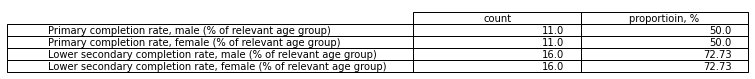



Croatia non-missing values in [2000, 2021] year range


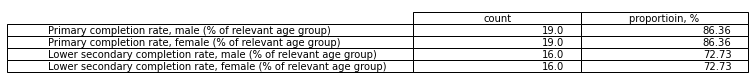



Afganistan non-missing values in [2000, 2021] year range


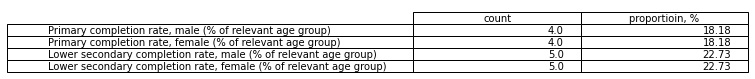

In [6]:
# Proportion (%) of non-missing values for each subindicator in each country:
plot_non_missing()

The prediction of the subindicators values in the furuture is done by linear modeling and defined in the _extrapolate_ function:

In [7]:
def extrapolate(future_year, years, values, degree, ma_window=None, last_k_years=None):
    if ma_window is not None:
        values = pd.Series(values).rolling(ma_window).mean().fillna(method='bfill')
    if last_k_years is not None:
        years = years[-last_k_years:]
        values = values[-last_k_years:]
    z = np.polyfit(years, values, deg=degree)
    f = np.poly1d(z)
    forward = future_year - max(years)
    extrapolation = f(list(years) + [i+max(years) for i in range(1, forward+1)])
    
    result = pd.Series(
        index=range(min(years), future_year+1),
        data=extrapolation
    )
    result.index = pd.to_datetime(result.index, format='%Y')
    return result



def plot_lines(
    county_code,
    degree=1,
    ma_window=None,
    last_k_years=None,
    bottom_ylim=0,
    top_ylim=100,
):
    _, ax = plt.subplots(figsize=(8,6))

    for sub_indicator in selected_subindicators:
        data = indicators[county_code][sub_indicator]
        data['processed'].plot(
            kind='line',
            label=sub_indicator,
            markevery=[data['processed'].index.get_loc(i) for i in data['original'].dropna().index],
            marker='o',
            markeredgecolor='black',
            markersize=10,
            ax=ax,
            alpha=0.6, 
        )

    for index, sub_indicator in enumerate(selected_subindicators):
        extrapolate(
            future_year,
            [i.year for i in ax.get_lines()[index].get_xdata()],
            ax.get_lines()[index].get_ydata(),
            degree=degree,
            ma_window=ma_window,
            last_k_years=last_k_years
        ).plot(
            kind='line', ax=ax, label='Model: ' + sub_indicator, linestyle='--', color=ax.get_lines()[index].get_color()
        )

    ax.axhline(100, 0, 1, color='black', linestyle='--', label='100% completion rate')
    plt.legend(bbox_to_anchor=(1, 0.75), loc='center left')
    plt.ylabel('% of relevant age group')
    plt.ylim(bottom=bottom_ylim, top=top_ylim)
    plt.xlim(left=date(year_range[0], 12, 31))
    x_ticks = pd.date_range(date(year_range[0], 12, 31), date(future_year, 12, 31), freq='Y')
    plt.xticks(ticks=x_ticks, labels=[d.year for d in x_ticks], rotation=90)
    plt.title(county_name[county_code])
    plt.grid()
    plt.show()

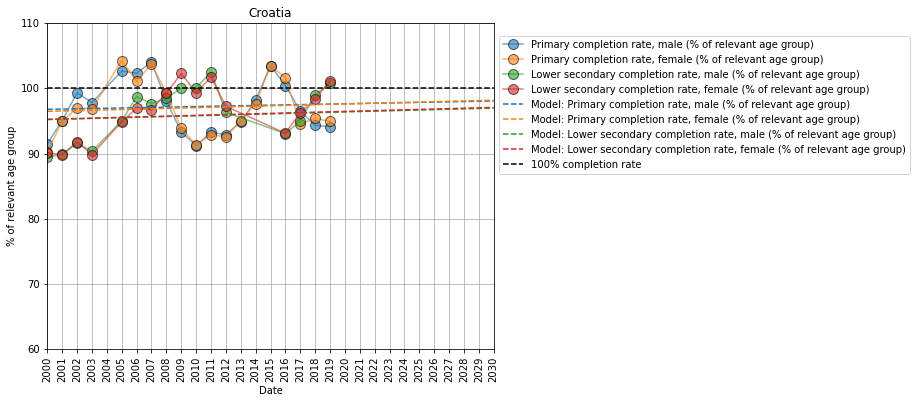

In [8]:
plot_lines(
    county_code = 'hrv',
    ma_window = 15,
    bottom_ylim=60,
    top_ylim=110
)

**Figure 1A. Completion rate subindincators change over time (solid lines) and linear modeling (Croatia).**  
Solid lines represent subindicator values, and dahsed lines represent linear trend modelling. Primary and lower secondary completion rate have similar dynamics for both male and female groups and the values fluctuate around 100%. According to the modeling, both primary and lower secondary completion rates have on average a positive trend and are expected to be close to 100% by 2030.

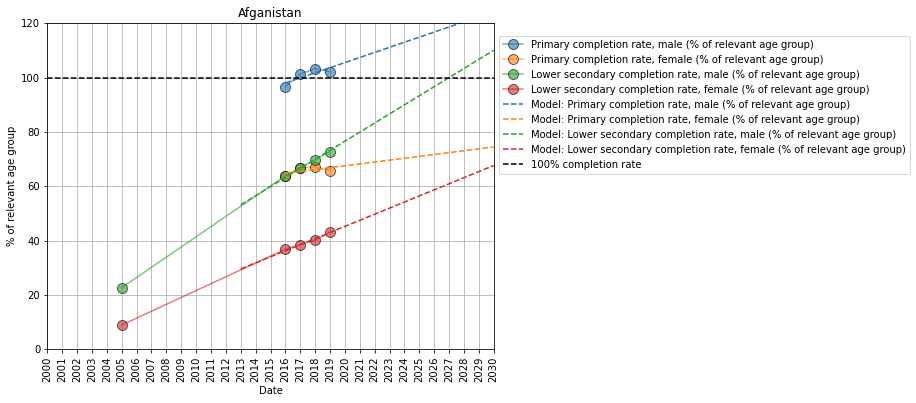

In [9]:
plot_lines(
    county_code = 'afg',
    last_k_years = 7,
    top_ylim=120
)

**Figure 1B. Completion rate subindincators change over time (solid lines) and linear modeling (Afganistan).**
There are fewer data available for Afganistan. However, there is an obvious difference between the groups of male and female in favor of the former. According to the trend line, the value of the both indicators will reach 100% by 2030 for the male group, but not for the female one.

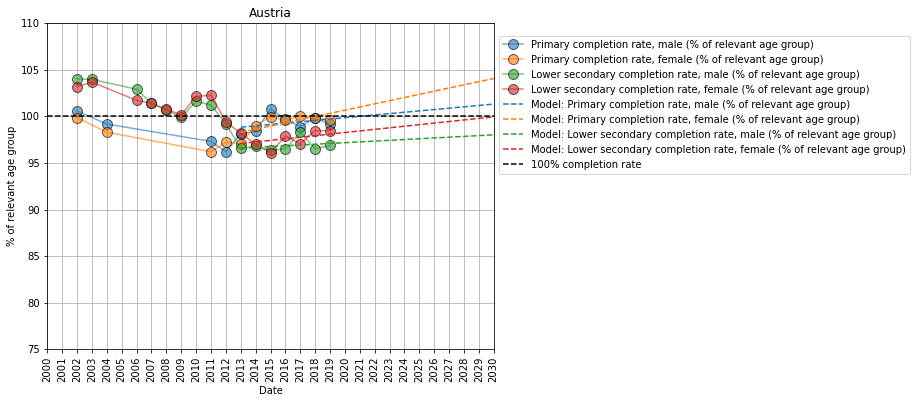

In [10]:
plot_lines(
    county_code = 'aut',
    last_k_years = 7,
    bottom_ylim=75,
    top_ylim=110
)

**Figure 1C. Completion rate subindincators change over time (solid lines) and linear modeling (Austria).**  
Primary and lower secondary completion rate have similar dynamics for both male and female groups. According to the modelling, primary completion rate show better dynamics and reach 100% for both male and female groups. The lower secondary completion rate indicator is slightly behind.

 
**Target:** 4.6 By 2030, ensure that all youth and a substantial proportion of adults, both men and women, achieve literacy and numeracy  
**Indicator:** 4.6.1 Proportion of population in a given age group achieving at least a fixed level of proficiency in functional (a) literacy and (b) numeracy skills, by sex  
 
**Subindicators:**  
1. Literacy rate, adult female (% of females ages 15 and above)
2. Literacy rate, adult male (% of males ages 15 and above)

**Countries:** Brazil, South Africa  
**Question:** What are the dynamics of adult literacy over the given period of years?

In [11]:
selected_countries = ['bra', 'zaf']

county_name = {
    'bra': 'Brazil',
    'zaf': 'South Africa'
}

selected_subindicators = [
    'Literacy rate, adult female (% of females ages 15 and above)',
    'Literacy rate, adult male (% of males ages 15 and above)'
]

colors = ['#ED2939', '#171796']


year_range = (2000, 2021)


# Load subindicator values in 2000 - 2021 year range for Brazil and South Africa and store in dict:
indicators = load_subindicators(selected_countries, selected_subindicators, year_range, pct=True)

Brazil non-missing values in [2000, 2021] year range


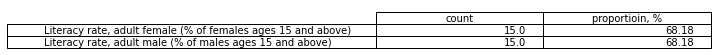



South Africa non-missing values in [2000, 2021] year range


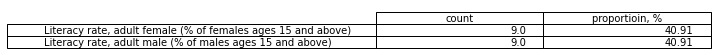

In [12]:
# Proportion (%) of non-missing values for each subindicator in each country:
plot_non_missing()

In [13]:
def plot_lines2(
    county_code,
    bottom_ylim=70,
    top_ylim=102,
    bar_lim=10
):
    _, (ax, *bar_ax) = plt.subplots(
        3, 1, figsize=(12,15), sharex=False, gridspec_kw={'height_ratios': [2, 1, 1]}
    )
    x_ticks = pd.date_range(date(year_range[0], 10, 15), date(future_year, 12, 31), freq='Y')
    
    for index, sub_indicator in enumerate(selected_subindicators):
        data = indicators[county_code][sub_indicator]
        years = list(data['processed'].index.year)
        
        sns.lineplot(
            x=years,
            y=data['processed'].values,
            label=sub_indicator,
            markevery=[
                data['processed'].index.get_loc(i)
                for i in data['original'].dropna().index
            ],
            marker='o',
            markeredgecolor='black',
            markersize=10,
            color=colors[index],
            ax=ax,
            alpha=0.6, 
        )
        sns.barplot(
            x=years,
            y=pd.Series(data['pct'], name='%, Annual Change'),
            hue=pd.Series(data['pct'], name='Annual Change').apply(
                lambda x: 'Positive' if x >= 0  else 'Negative'
            ),
            palette={'Positive': 'green', 'Negative': 'red'},
            ax=bar_ax[index],
            dodge=False
        )

        bar_ax[index].set_title(sub_indicator)
        bar_ax[index].grid(True)
        bar_ax[index].set_ylim(bottom=-bar_lim, top=bar_lim)
        
    ax.axhline(100, 0, 1, color='black', linestyle='--', label='100% literacy rate')
    ax.set_ylabel('% of relevant group ages 15 and above')
    ax.legend() 
    ax.grid()
    ax.set_ylim(bottom=bottom_ylim, top=top_ylim)
    ax.set_xticks(ticks=years, labels=years, rotation=90)
    ax.set_title(county_name[county_code])


    
    plt.tight_layout()
    plt.show()

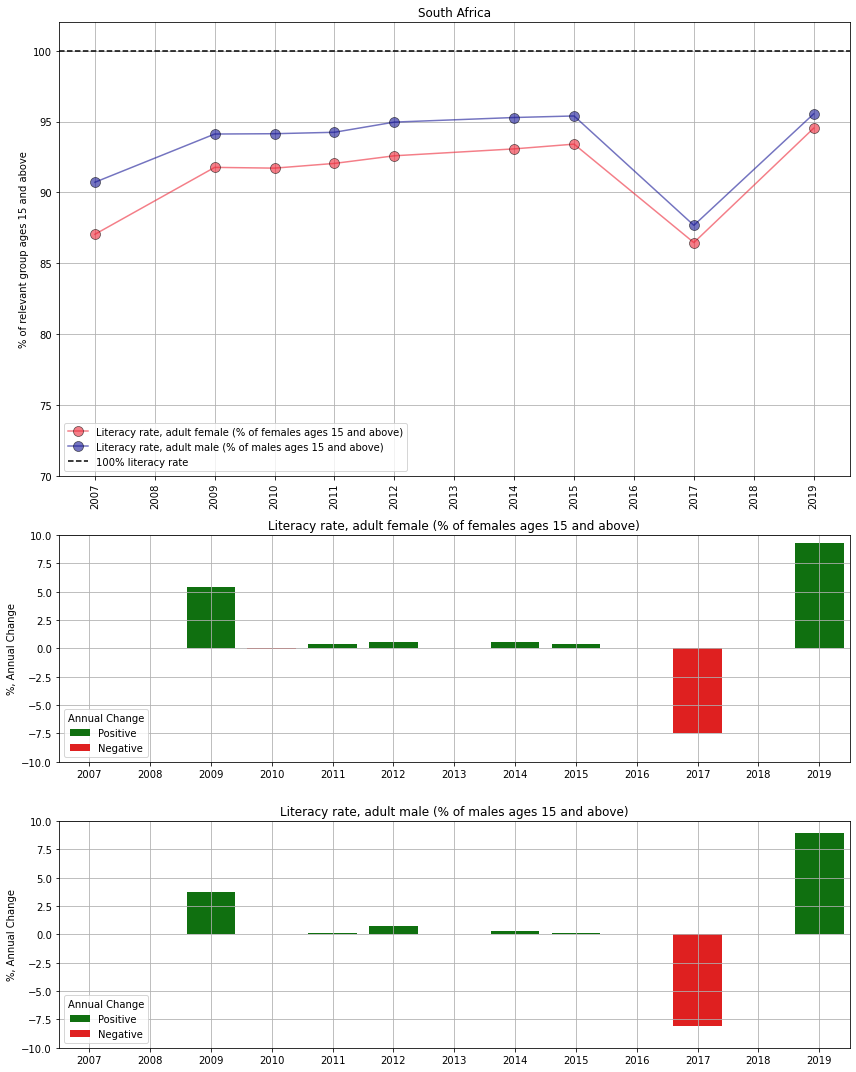

In [14]:
plot_lines2(county_code='zaf')

**Figure 2A. Proportion of literacy population among adults over time (South Africa).**  
* South Africa adult female literacy rate for 2019 was 94.53%, a 8.61% increase from 2007.
* South Africa adult female literacy rate for 2017 was 86.46%, a 7.44% decline from 2015.
* South Africa adult male literacy rate for 2019 was 95.55%, a 5.32% increase from 2007.
* South Africa adult male literacy rate for 2017 was 87.67%, a 8.09% decline from 2015.

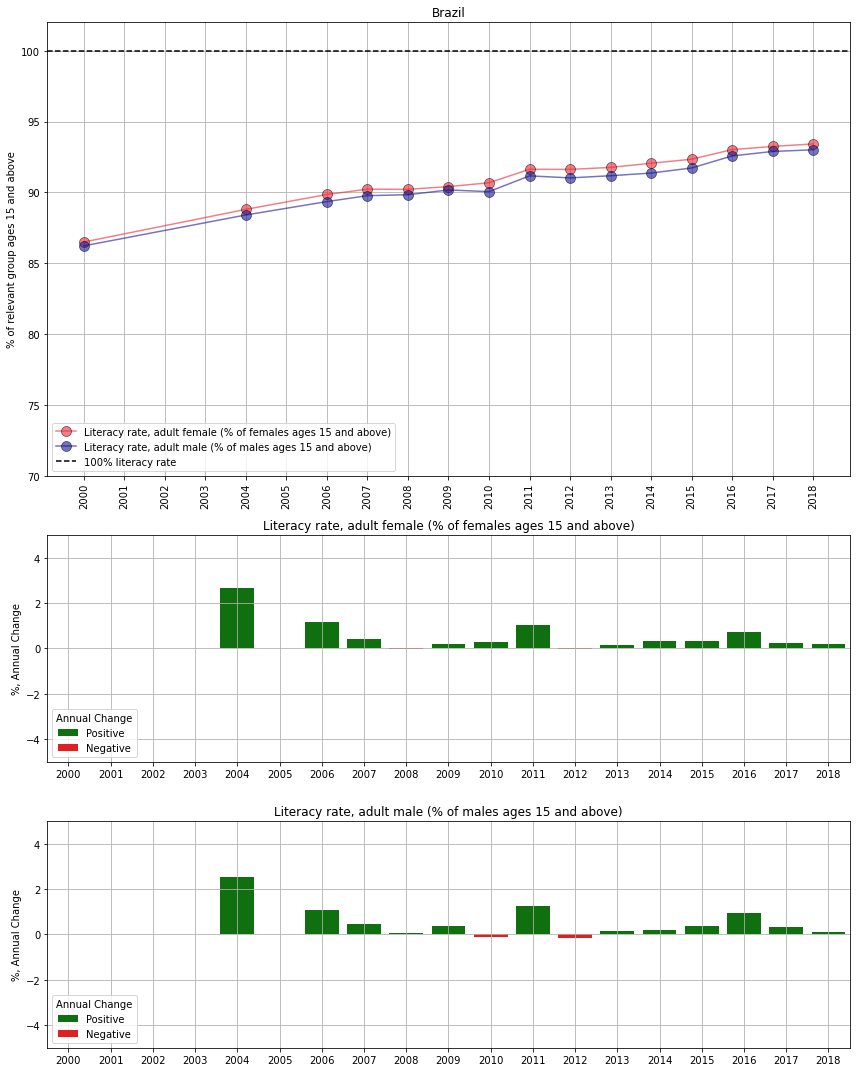

In [15]:
plot_lines2(county_code='bra', bar_lim=5)

**Figure 2A. Proportion of literacy population among adults over time (Brazil).**

* Brazil adult female literacy rate for 2018 was 93.43%, a 8.01% increase from 2004.
* Brazil adult male literacy rate for 2018 was 93.01%, a 7.86% increase from 2004.

 
**Target:** 4.5 By 2030, eliminate gender disparities in education and ensure equal access to all levels of education and vocational training for the vulnerable, including persons with disabilities, indigenous peoples and children in vulnerable situations  
**Indicator:** 4.5.1 Parity indices (female/male, rural/urban, bottom/top wealth quintile and others such as disability status, indigenous peoples and conflict-affected, as data become available) for all education indicators on this list that can be disaggregated
az**Subindicators:**  
1. School enrollment, primary (gross), gender parity index (GPI)  
2. School enrollment, secondary (gross), gender parity index (GPI)  
**Countries:** Austria, Croatia, and Afghanistan  
**Year range:** 2000 - 2021
**Question:** Can the enrollment in primary and secondary education of the male and female groups (in the future time period) reach the same conditions？  

In [16]:
selected_countries = ['aut', 'hrv', 'afg']

county_name = {
    'aut': 'Austria',
    'hrv': 'Croatia',
    'afg': 'Afghanistan'
}

selected_subindicators = {
    'PRIM': 'School enrollment, primary (gross), gender parity index (GPI)',
    'SECO': 'School enrollment, secondary (gross), gender parity index (GPI)',
}

year_range = (2000, 2021)
future_year = 2030


subindicator_codes_list = ['PRIM', 'PRSC', 'SECO', 'TERT']

def year_bins(lst, bin_size):
    start = 0
    end = 0
    result = []
    for i in range(1, len(lst)+1):
        if i % bin_size == 0:
            end = i   
        elif i == len(lst):
            end = len(lst)
        if start < end:
            result.append(lst[start: end])
            start = end
    return result

data = dict()
for su in subindicator_codes_list:
    data[su] = pd.read_csv(f'SE.ENR.{su}.FM.ZS.csv', sep='\t').iloc[1:, 1:].drop(columns=['Is Selected Country'])
    data[su] = data[su].set_index(data[su].columns[0])
    data[su].index.name = 'Region'
    data[su].columns = data[su].columns.astype(int)
    data[su] = data[su].reindex(columns=range(year_range[0], year_range[1]+1))
    _dict = dict()
    for interval in year_bins(
        lst=list(range(year_range[0], year_range[1]+1)),
        bin_size=5
    ):
        _dict[f'{interval[0]}-{interval[-1]}'] = data[su][interval].median(axis=1)
    data[su] = pd.DataFrame(_dict)

In [17]:
country_region = pd.read_csv('country_region.csv')[['Country Code', 'Region Name']].drop_duplicates()
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world['Region'] = world['iso_a3'].map(country_region.set_index('Country Code')['Region Name'])

world.loc[2, 'Region'] = 'Middle East & North Africa'
world.loc[12, 'Region'] = 'Sub-Saharan Africa'
world.loc[16, 'Region'] = 'Latin America & Caribbean'
world.loc[20, 'Region'] = 'Latin America & Caribbean'
world.loc[22, 'Region'] = 'North America'
world.loc[30, 'Region'] = 'Latin America & Caribbean'
world.loc[62, 'Region'] = 'Sub-Saharan Africa'
world.loc[77, 'Region'] = 'Middle East & North Africa'
world.loc[134, 'Region'] = 'East Asia & Pacific'
world.loc[135, 'Region'] = 'East Asia & Pacific'
world.loc[140, 'Region'] = 'East Asia & Pacific'
world.loc[160, 'Region'] = 'Middle East & North Africa'
world.loc[167, 'Region'] = 'Sub-Saharan Africa'
world.loc[174, 'Region'] = 'Europe & Central Asia'




In [18]:


def process_subindicator2(sub_indicator, country_code, year_min, year_max, pct=False):
    data = df[country_code][df[country_code]['Indicator Name'].eq(sub_indicator)].set_index('Year')['Value']
    data = data.reindex(range(year_min, year_max+1))
    _dict = dict()
    for interval in year_bins(
        lst=list(range(year_min, year_max+1)), bin_size=5
    ):
        _dict[f'{interval[0]}-{interval[-1]}'] = data.loc[interval].median()
    return pd.Series(_dict)

def load_subindicators2(selected_countries, selected_subindicators, year_range):
    indicators = dict()
    for sub_indicator_code, sub_indicator in selected_subindicators.items():
        indicators[sub_indicator_code] = dict()
        for county_code in selected_countries:
            indicators[sub_indicator_code][county_code.upper()] = dict()
            indicators[sub_indicator_code][county_code.upper()] = process_subindicator2(
                sub_indicator,
                county_code,
                year_range[0],
                year_range[1],
            )
        indicators[sub_indicator_code] = pd.DataFrame(indicators[sub_indicator_code]).T
    return indicators

# Load subindicator values in 2000 - 2021 year range for Austria, Croatia, Afganistan and store in dict:
indicators = load_subindicators2(selected_countries, selected_subindicators, year_range)

School enrollment, primary (gross), gender parity index (GPI)


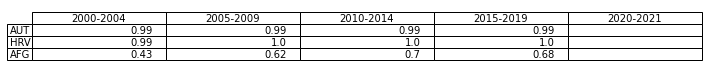



School enrollment, secondary (gross), gender parity index (GPI)


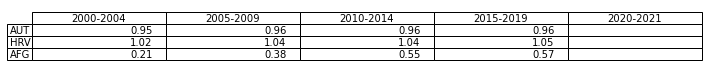

In [19]:
# Values are missing for years 2020 and 2021
for sub_code, sub_name in selected_subindicators.items():

    print(sub_name)
    _, ax = plt.subplots(figsize=(12,0.1))
    pd.plotting.table(ax=ax, data=indicators[sub_code].round(2).fillna(''))
    plt.axis('off')
    plt.show()
    print('\n')

In [20]:
def plot_map(LW, SU, INTERVAL, VMIN, VMAX, title=None, show=False):
    fig, ax = plt.subplots(figsize=(17,9))


    regions = world.assign(
        **{f'{SU}: {INTERVAL}': np.exp(-abs(np.log(world['Region'].map(data[SU][INTERVAL]))))}
    ).dissolve(by='Region', aggfunc='mean')
    regions.plot(
        column=f'{SU}: {INTERVAL}',
        cmap='OrRd', ax=ax, edgecolor='dimgrey',
        vmin=VMIN, vmax=VMAX
    )

    countries = world.assign(
        **{f'{SU}: {INTERVAL}': np.exp(-abs(np.log(world['iso_a3'].map(indicators[SU][INTERVAL]))))}
    )[world['iso_a3'].str.lower().isin(selected_countries)]
    countries.plot(
        column=f'{SU}: {INTERVAL}',
        cmap='OrRd', ax=ax, edgecolor='k', linewidth=LW/3,
        vmin=VMIN, vmax=VMAX
    )

    coords = world[world['iso_a3'].str.lower().eq('aut')]['geometry'].squeeze().bounds
    ax.plot([coords[2]-2, -6.6], [coords[3]+1, 57.5], color='k', lw=LW)
    ax.plot([coords[2], 0], [coords[3]-7, 20], color='k', lw=LW)
    ax.scatter(-30, 36, s=30000, fc='#FAF9F6', ec='k', lw=LW)
    plt.axis('off')
    ax2 = plt.axes([.35, .5, .2, .2])
    countries[countries['iso_a3'].str.lower().isin(['hrv', 'aut'])].plot(
        column=f'{SU}: {INTERVAL}',
        cmap='OrRd', ax=ax2, edgecolor='k', linewidth=LW/1.5,
        vmin=VMIN, vmax=VMAX
    )
    plt.axis('off')

    coords = world[world['iso_a3'].str.lower().eq('afg')]['geometry'].squeeze().bounds
    ax.plot([coords[2]-2, 99], [coords[3]-3, 5], color='k', lw=LW)
    ax.plot([coords[0]-1, 35], [coords[3]-3, 9.5], color='k', lw=LW)
    ax.scatter(65, -10, s=35000, fc='#FAF9F6', ec='k', lw=LW)
    plt.axis('off')
    ax3 = plt.axes([.545, .28, .2, .2])
    countries[countries['iso_a3'].str.lower().eq('afg')].plot(
        column=f'{SU}: {INTERVAL}',
        cmap='OrRd', ax=ax3, edgecolor='k', linewidth=LW/1.5,
        vmin=VMIN, vmax=VMAX
    )
    plt.axis('off')

    cax = fig.add_axes([0.15, 0.15, 0.02, 0.4])
    ticks = np.linspace(VMIN, VMAX, 7, endpoint=True)
    sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=VMIN, vmax=VMAX))
    plt.colorbar(sm, cax=cax, ticks=ticks, ax=ax)
    if title is not None:
        plt.suptitle(title, fontsize=15, y=0.95)
    ax.set_title(
        INTERVAL + ':    ' +
        '  '.join(f'{county_name[k.lower()]}: {round(v, 2)}' for k, v in indicators[SU][INTERVAL].iteritems()) +
        '   ||   ' +
        '  '.join(f'{k}: {round(v, 2)}' for k, v in data[SU][INTERVAL].iteritems() if k in ['Europe & Central Asia', 'South Asia'])
    )
    if show:
        plt.show()

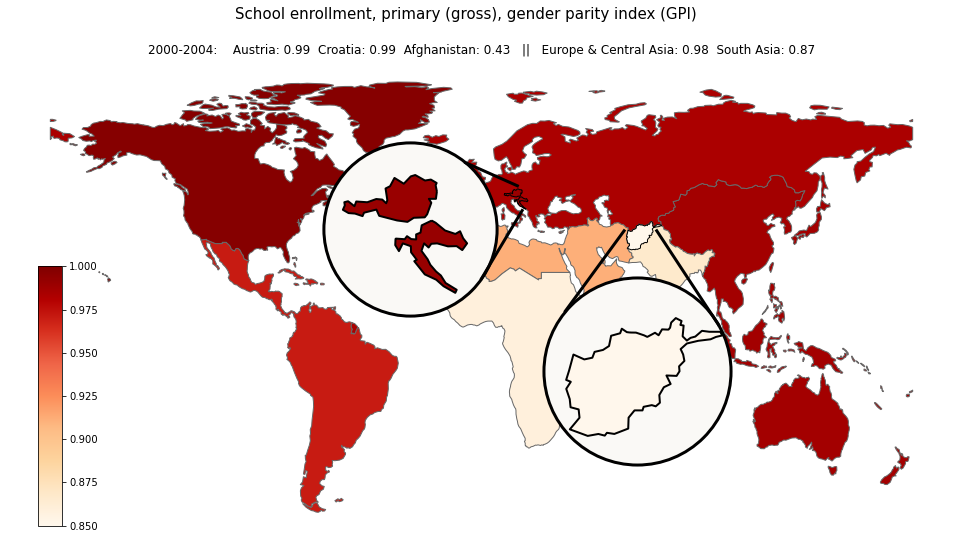

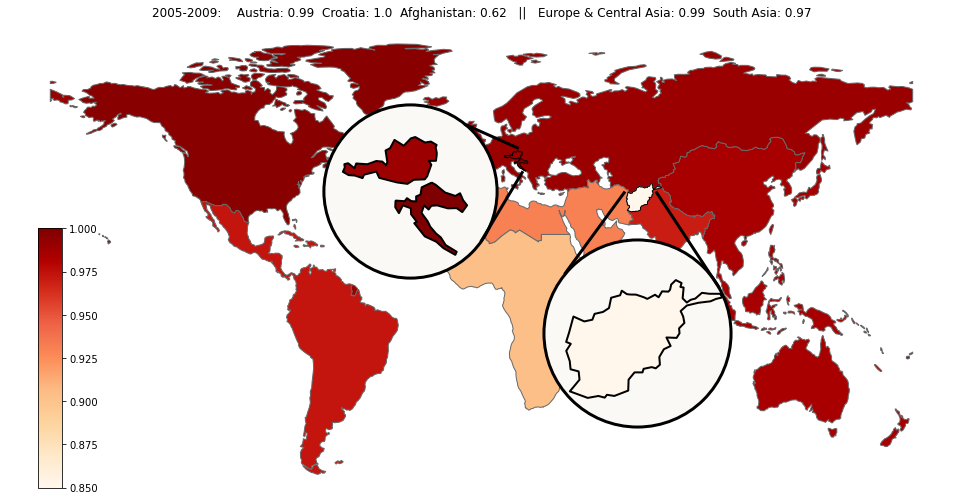

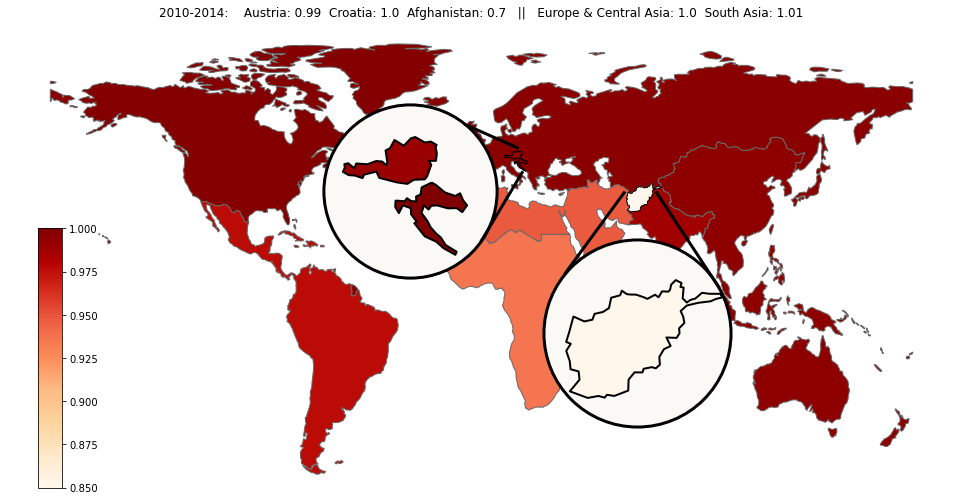

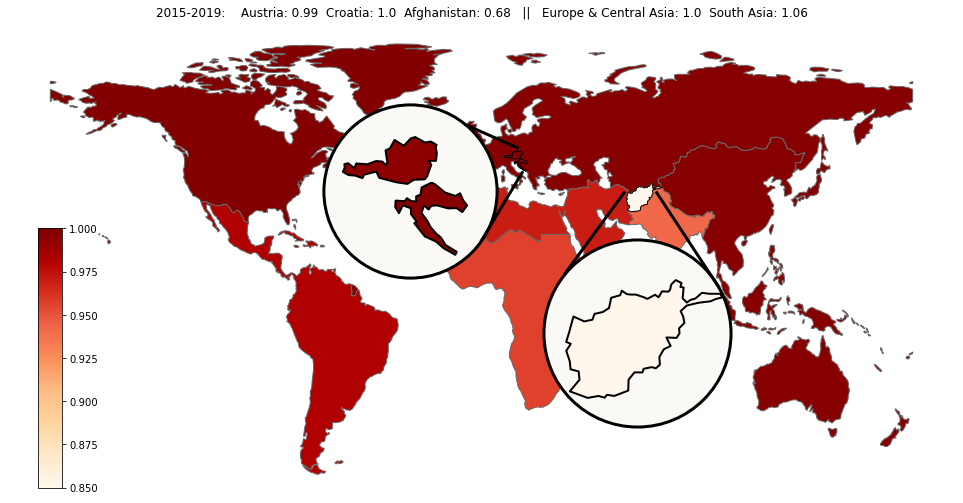

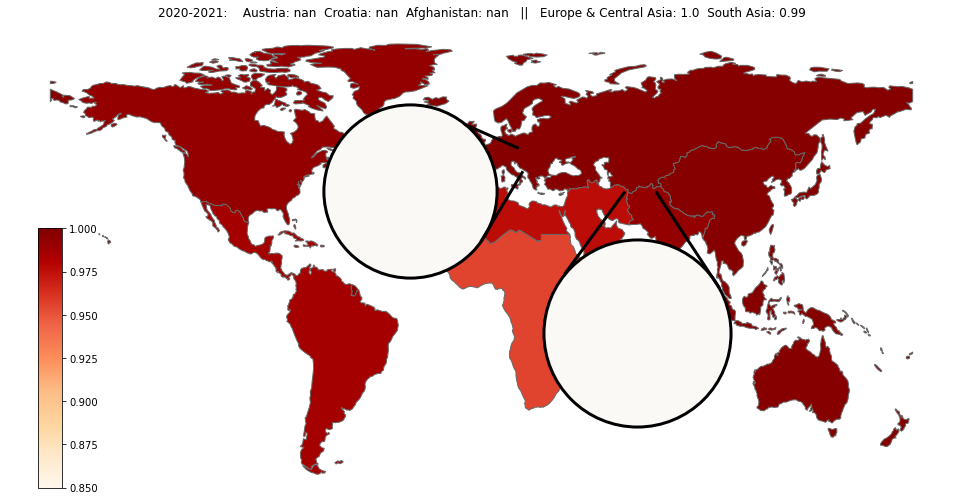

In [21]:
yb = year_bins(lst=list(range(year_range[0], year_range[1]+1)), bin_size=5)

LW =3
VMIN = 0.85
VMAX = 1
SU = 'PRIM'

plot_map(LW=LW, SU=SU, INTERVAL=f'{yb[0][0]}-{yb[0][-1]}', VMIN=VMIN, VMAX=VMAX, title=selected_subindicators[SU], show=False)
for interval in yb[1:-1]:
    plot_map(LW=LW, SU=SU, INTERVAL=f'{interval[0]}-{interval[-1]}', VMIN=VMIN, VMAX=VMAX, title=None, show=False)
plot_map(LW=LW, SU=SU, INTERVAL=f'{yb[-1][0]}-{yb[-1][-1]}', VMIN=VMIN, VMAX=VMAX, title=None, show=False)


**Figure 3A. Dynamics of primary school enrollment (GPI) in the countries of interest and corresponding regions.**

The GPI value is calculated by dividing the female value for the indicator by the male value for the indicator. A GPI equal to 1 indicates parity between females and males. In general, a value less than 1 indicates disparity in favor of males and a value greater than 1 indicates disparity in favor of females. Note that colors in the chart indicate GPI values which are symmetric with respect to one, e.g 1.05 is going to have the same color as 0.95.

According to the figure, primary school enrollment GPI vaue is constantly high and close to 1 in Austria and Croatina. However, after improvement in the first decade (2000 - 2010) from 0.43 to 0.7, primary school enrollment GPI reaches plateau in Afghanistan.


We can assume that in the near future in Croatia and Austria GPI will fluctuate around one, but it is not known whether Afghanistan will come out of the plateau, and if so, where the dynamics will be directed.

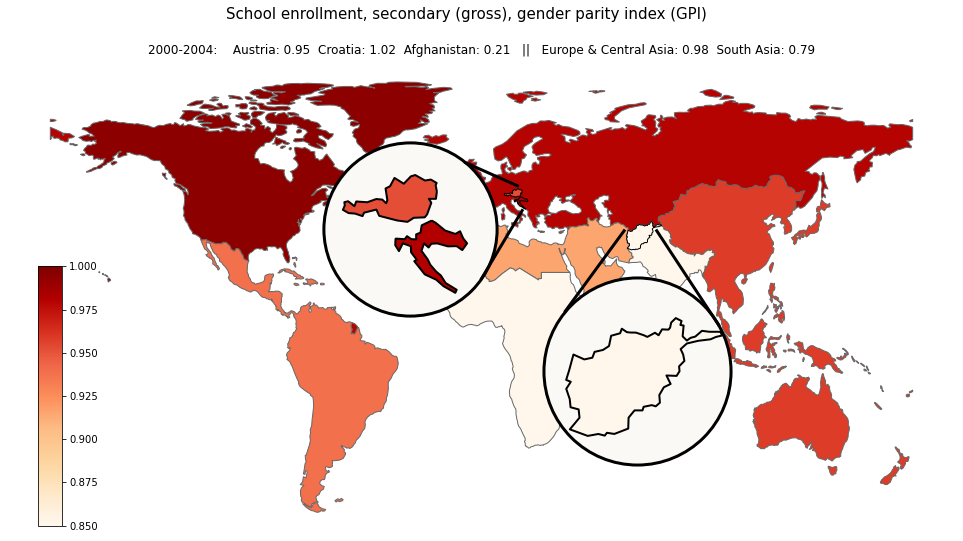

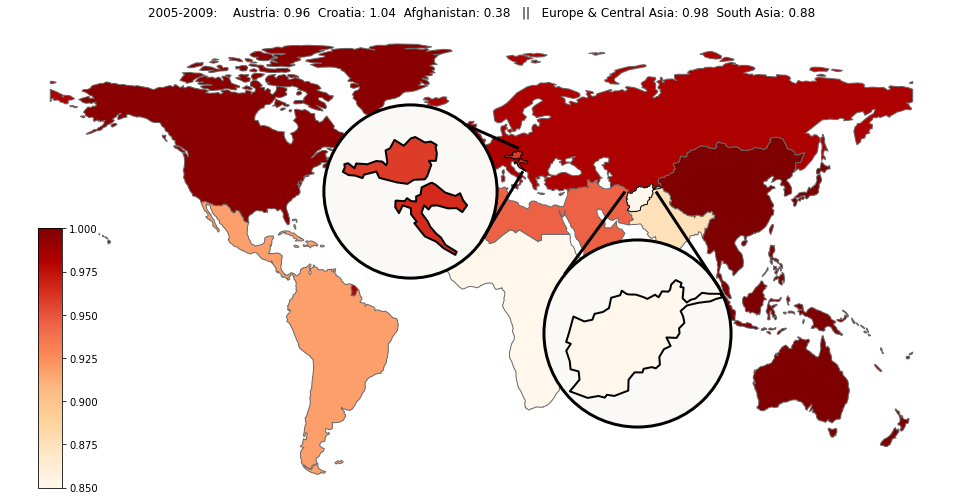

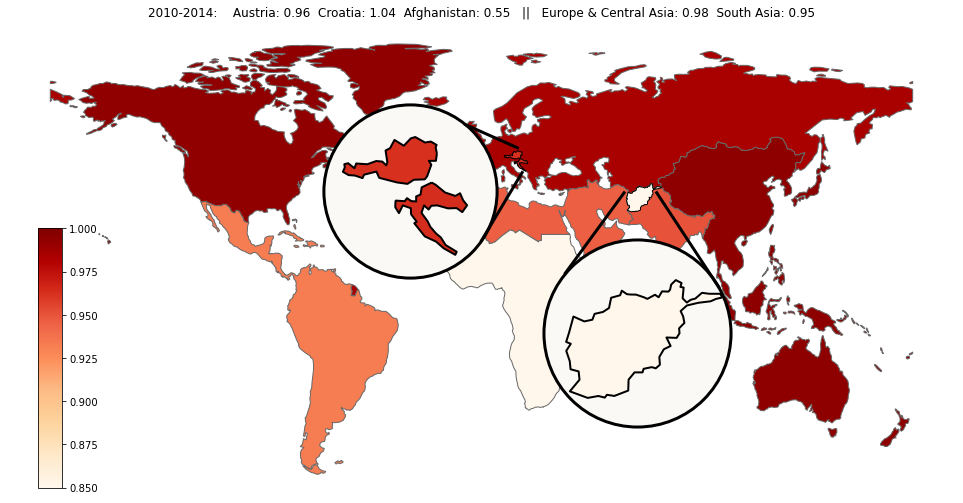

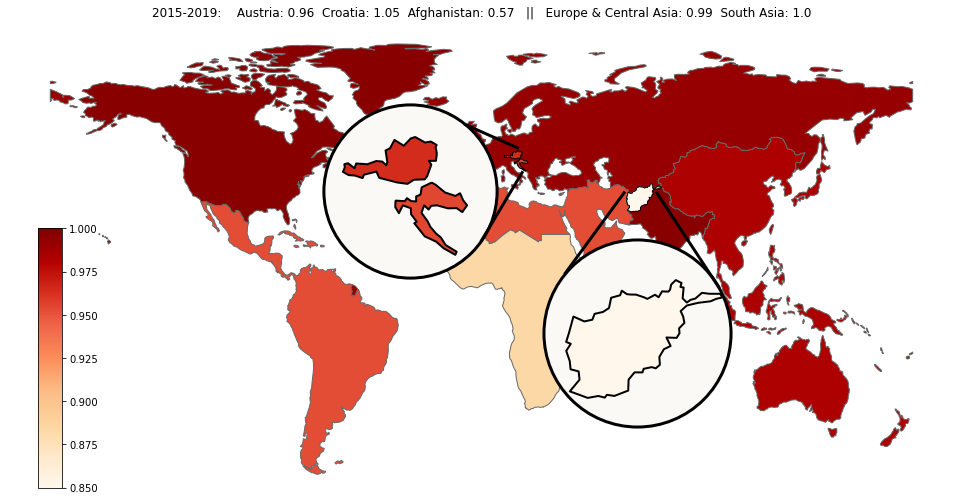

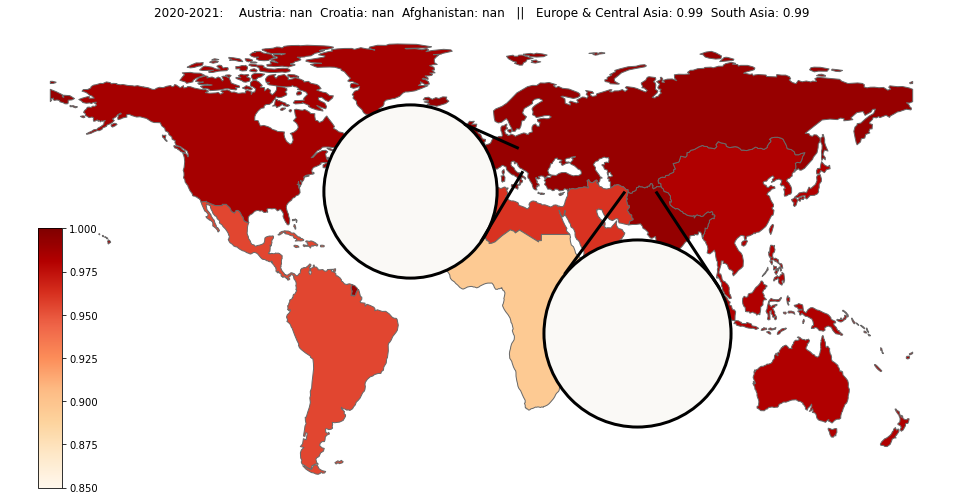

In [22]:
yb = year_bins(lst=list(range(year_range[0], year_range[1]+1)), bin_size=5)

LW =3
VMIN = 0.85
VMAX = 1
SU = 'SECO'

plot_map(LW=LW, SU=SU, INTERVAL=f'{yb[0][0]}-{yb[0][-1]}', VMIN=VMIN, VMAX=VMAX, title=selected_subindicators[SU], show=False)
for interval in yb[1:-1]:
    plot_map(LW=LW, SU=SU, INTERVAL=f'{interval[0]}-{interval[-1]}', VMIN=VMIN, VMAX=VMAX, title=None, show=False)
plot_map(LW=LW, SU=SU, INTERVAL=f'{yb[-1][0]}-{yb[-1][-1]}', VMIN=VMIN, VMAX=VMAX, title=None, show=False)


**Figure 3B. Dynamics of secondary school enrollment (GPI) in the countries of interest and corresponding regions.**

Secondary school enrollment GPI vaue in Austria is heading towards gender equalty (which means to 1). In turn, in Croatia it moves away from one in an upwards direction. Afghanistan secondary school enrollment GPI increases quite rapidly from 0.21 in 2000-2004 to 0.57 in 2015-2019.

Note that colors indicate GPI values are symmetric with respect to one, e.g 1.05 is going to have the same color as 0.95

First, there is a global trend in favor of increasing the GPI, in Croatia it is even higher than 1 and continues to grow. The most obvious growth is in Afghanistan and by the direction of the trend we can assume that in the future growth will continue .

 
**Target:** 4.4 By 2030, substantially increase the number of youth and adults who have relevant skills, including technical and vocational skills, for employment, decent jobs and entrepreneurship
**Indicator:** 4.4.1 Proportion of youth and adults with information and communications technology (ICT) skills, by type of skill 
 
**Subindicators:**  
1. Educational attainment, at least completed primary, population 25+ years, male (%) (cumulative)

**Countries:** Brazil, South Africa  
**Question:** What are the dynamics of male primary completion?

In [23]:
selected_countries = ['bra', 'zaf']

county_name = {
    'bra': 'Brazil',
    'zaf': 'South Africa'
}

selected_subindicators = [
    'Educational attainment, at least completed primary, population 25+ years, male (%) (cumulative)',
]

colors = ['#ED2939', '#171796']


year_range = (2000, 2021)


# Load subindicator values in 2000 - 2021 year range for Brazil and South Africa and store in dict:
indicators = load_subindicators(selected_countries, selected_subindicators, year_range, pct=True)

In [24]:
def plot_lines3(
    county_code,
    bottom_ylim=70,
    top_ylim=102,
    bar_lim=10
):
    _, ax = plt.subplots(
        figsize=(10,5)
    )
    x_ticks = pd.date_range(date(year_range[0], 10, 15), date(future_year, 12, 31), freq='Y')
    
    for index, sub_indicator in enumerate(selected_subindicators):
        data = indicators[county_code][sub_indicator]
        years = list(data['processed'].index.year)
        
        sns.lineplot(
            x=years,
            y=data['processed'].values,
            label=sub_indicator,
            markevery=[
                data['processed'].index.get_loc(i)
                for i in data['original'].dropna().index
            ],
            marker='o',
            markeredgecolor='black',
            markersize=10,
            color=colors[index],
            ax=ax,
            alpha=0.6)


    ax.legend()
    ax.grid()
    ax.set_ylim(bottom=bottom_ylim, top=top_ylim)
    ax.set_xticks(ticks=years, labels=years, rotation=90)
    ax.set_title(county_name[county_code])


    
    plt.tight_layout()
    plt.show()

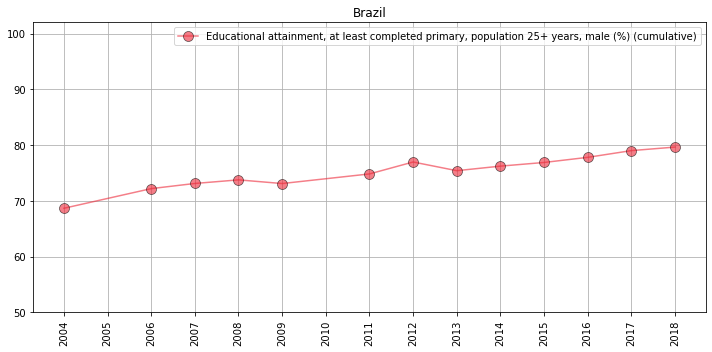

In [25]:
plot_lines3('bra', 50)

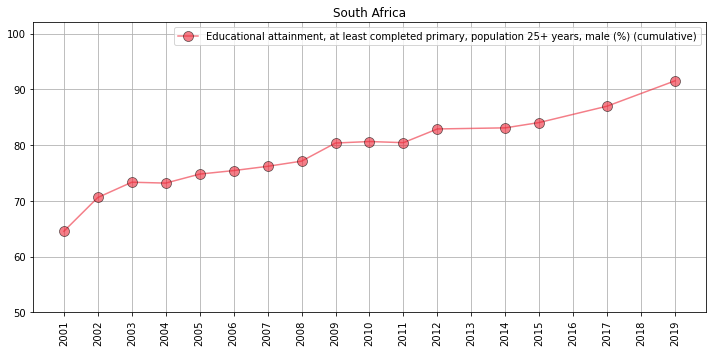

In [26]:
plot_lines3('zaf', 50)